# Privacy-preserving machine learning

In thess notebooks we will discuss the main concepts of Federated Learning(FL). 
Consider a classic ML model, but in a situation where the data owner(DO) would prefer to not expose his data. In this case, what a data scientis(DS) can do is to create a base model and train it on the DO's side. In case we have multiple data owners, the procedure is very simiar, but in the end we aggregate the final models. The advantages are are data privacy and the reduction of the computational costs, since the data might be distributed among several DO's.

PySyft(https://github.com/OpenMined/PySyft) is a library a library designed to provide an orchistration between the DS and the DO(s).

# Part 0: Setup Data Scientist

#### Now open the DO1 notebook and let's get started (Jump 0.0)

Join the Duet Server data owner 1 connected to.

In [1]:
import syft as sy
#duet1 = sy.join_duet(loopback=True)
#duet1 = sy.join_duet('INSERT_DUET_SERVER_ID', network_url="http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000")
duet1 = sy.join_duet('a27c8bc011af31164a3e3d164d4e0190', network_url="http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 62ed5faa7d167002ba8cb23a665dc04d

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


Join the Duet Server the Data Owner 2 connected to.

In [2]:
#duet2 = sy.join_duet(loopback=True)
#duet2 = sy.join_duet('INSERT_DUET_SERVER_ID', network_url="http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000")
duet2 = sy.join_duet('c42fcad4f6c305ad1921bf250a72048e', network_url="http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000")

🎤  🎸  ♪♪♪ Joining Duet ♫♫♫  🎻  🎹

♫♫♫ > DISCLAIMER: Duet is an experimental feature currently in beta.
♫♫♫ > Use at your own risk.


    > ❤️ Love Duet? Please consider supporting our community!
    > https://github.com/sponsors/OpenMined

♫♫♫ > Punching through firewall to OpenGrid Network Node at:
♫♫♫ > http://ec2-3-15-165-254.us-east-2.compute.amazonaws.com:5000
♫♫♫ >
♫♫♫ > ...waiting for response from OpenGrid Network... 
♫♫♫ > DONE!

♫♫♫ > STEP 1: Send the following Duet Client ID to your duet partner!
♫♫♫ > Duet Client ID: 8e1852e377bd999f66c3843a47574814

♫♫♫ > ...waiting for partner to connect...

♫♫♫ > CONNECTED!


# Part 2: Working With The Data

### 2.1 Data Description
The data scientist can check the list of searchable data in Data Owner's duet store

In [3]:
duet1.store.pandas

,ID,Tags,Description,object_type
0,<UID: 10e9a8184ffa42c8835b0712f8c602cc>,[Wine-data],Wine quality dataset #1 with 13 features (Alco...,<class 'torch.Tensor'>
1,<UID: baca0f2c081b446399cc2d0da441e82e>,[Wine-labels],"Labels for wine: class_0, class_1, class_2",<class 'torch.Tensor'>


In [4]:
duet2.store.pandas

,ID,Tags,Description,object_type
0,<UID: 602738e8807e4eb08ea630794820f471>,[Wine-data],Wine quality dataset #2 with 13 features (Alco...,<class 'torch.Tensor'>
1,<UID: 885d601cf5644ebd9a1efcf46144bd9e>,[Wine-labels],"Labels for wine: class_0, class_1, class_2",<class 'torch.Tensor'>


Now let us get the pointers to the data and the target for both DOs and read the descririptions provided to us

In [5]:
data_ptr1 = duet1.store["Wine-data"] # or duet1.store[0]
target_ptr1 = duet1.store["Wine-labels"] # or duet1.store[1]

print(data_ptr1)
print(duet1.store.pandas["Description"][0])
print()
print(target_ptr1)
print(duet1.store.pandas["Description"][1])

Wine quality dataset #1 with 13 features (Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline)

Labels for wine: class_0, class_1, class_2


In [6]:
data_ptr2 = duet2.store["Wine-data"] # or duet2.store[0]
target_ptr2 = duet2.store["Wine-labels"] # or duet2.store[1]

print(data_ptr2)
print(duet2.store.pandas["Description"][0])
print()
print(target_ptr2)
print(duet2.store.pandas["Description"][1])

Wine quality dataset #2 with 13 features (Alcohol, Malic acid, Ash, Alcalinity of ash, Magnesium, Total phenols, Flavanoids, Nonflavanoid phenols, Proanthocyanins, Color intensity, Hue, OD280/OD315 of diluted wines, Proline)

Labels for wine: class_0, class_1, class_2


### 2.2 Requests in PySyft
Imagine a scenario where a DS needs know some statistics of the data, say, the mean value of an Alcohol. DO requests the result which, in turn, the DO can either decline or accept.
Now we will apply the mean of the first column with respect to the pointer and try to get the result. It will cause an exeption since we are not allowed to get the data directly. Thus, as it was said before we will create a request with the reason.

In [7]:
average_alco1 = data_ptr1.mean(axis = 0)[0]

In [8]:
try:
    average_alco1.get()
except Exception as e:
    print(e)

[2022-04-22T18:17:26.088672+0200][CRITICAL][logger]][2792] You do not have permission to .get() Object with ID: <UID: 3307ad3bf4304915b29834d293ab044c>Please submit a request.


You do not have permission to .get() Object with ID: <UID: 3307ad3bf4304915b29834d293ab044c>Please submit a request.


In [9]:
average_alco1.request(
    reason="I NEED AN AVERAGE YOU DONUT!!!"
)

#### Now open the DO1 notebook and check the live status (Jump 2.1)

In [10]:
try:
    average_alco1.get()
except Exception as e:
    print(e)

[2022-04-22T18:17:48.024754+0200][CRITICAL][logger]][2792] You do not have permission to .get() Object with ID: <UID: 3307ad3bf4304915b29834d293ab044c>Please submit a request.


You do not have permission to .get() Object with ID: <UID: 3307ad3bf4304915b29834d293ab044c>Please submit a request.


The request has been denied, what a pitty. Now we shall request the mean value of an Alcohol from the DO2 with a proper request this time.

In [11]:
average_alco2 = data_ptr2.mean(axis = 0)[0]

In [12]:
try:
    average_alco2.get()
except Exception as e:
    print(e)

[2022-04-22T18:18:01.905072+0200][CRITICAL][logger]][2792] You do not have permission to .get() Object with ID: <UID: 77a22d7279074758b0daca088b45956d>Please submit a request.


You do not have permission to .get() Object with ID: <UID: 77a22d7279074758b0daca088b45956d>Please submit a request.


In [13]:
average_alco2.request(
    reason="I would be very gratefull if you could possibly provide me the average alcohol for my research OwO"
)

#### Now open the DO2 notebook and check the live status (Jump 2.3)

Now when the request is accepted, we can display the value and, if needed, return to the DO2 notebook and find that the retrieved value and the mean aclohol are, indeed, equal.

In [14]:
avg1 = average_alco2.get()
print(avg1)

tensor(13.0154)


# Part 3: Creating and training the models

Before we will create the model, let us discuss one thing. During the training at each epoch we will be requesting the data from the DOs. In our case the number of epochs is not that big, but in reality this value can be quite large. In order to not switch between the notebooks every single time we can automatically accept or deny the requests by using request handlers.
#### Get to the DO1 notebook (Jump 3.1)

### 3.1 Model architecture
Now we shall import some libraries to build the model and work with the data

In [15]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.metrics import accuracy_score

In [16]:
input_features = 13 #number of features
out_features = 3 #number of classes

The model is created using PyTorch. What makes this framework perfect for PySyft is that it operates with tensors too. The model consists of two fully connected layers each one of which is followed by a batch normalization layer with an activation function and an output layer with a softmax, since we are dealing with a classification problem. If you are unfamiliar with PyTorch, refer to the folowing link: https://pytorch.org/docs/stable/index.html

In [17]:
class SyNet(sy.Module):
    def __init__(self, torch_ref):
        super(SyNet, self).__init__(torch_ref=torch_ref)
        self.fc1 = self.torch_ref.nn.Linear(input_features, 96)
        self.fc1_bn=self.torch_ref.nn.BatchNorm1d(96)
        
        self.fc2 = self.torch_ref.nn.Linear(96, 96)
        self.fc2_bn=self.torch_ref.nn.BatchNorm1d(96)
        
        self.fc3 = self.torch_ref.nn.Linear(96, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.torch_ref.nn.functional.relu(self.fc1_bn(x))
        
        x = self.fc2(x)
        x = self.torch_ref.nn.functional.relu(self.fc2_bn(x))
        
        #x = self.fc2(x)
        x = self.fc3(x)
        output = self.torch_ref.nn.functional.log_softmax(x, dim=1)# since it is a classification problem
        return output

 Create a local model

In [18]:
local_model = SyNet(torch)

Send a copy of a model to each of the Data Owners

In [19]:
remote_model1 = local_model.send(duet1)
remote_model2 = local_model.send(duet2)

Now we will create aliases to DOs’s torches called remote_torch1 and remote_torch2. Thus we will be able to refer to the local torch as torch and any operation we want to do remotely as remote_torch. This will help us to identify who is who and to perform the training independently. It is important that everything retured from remote_torch1 and remote_torch2 are Pointers, not the real objects!

In [20]:
remote_torch1 = duet1.torch
remote_torch2 = duet2.torch

Let's create pointers to parameters and optimizers for each of the models

In [21]:
params1 = remote_model1.parameters()
optim1 = remote_torch1.optim.Adam(params=params1, lr=0.01)
print("Pointers to Data owner 1's side:")
print("params:", params1)
print("optim:", optim1)

params2 = remote_model2.parameters()
optim2 = remote_torch2.optim.Adam(params=params2, lr=0.01)
print("Pointers to Data owner 2's side:")
print("params:", params2)
print("optim:", optim2)

Pointers to Data owner 1's side:
params: <syft.proxy.syft.lib.python.ListPointer object at 0x000001DCB705C2E0>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x000001DCBAA092E0>
Pointers to Data owner 2's side:
params: <syft.proxy.syft.lib.python.ListPointer object at 0x000001DCB7CB6D30>
optim: <syft.proxy.torch.optim.AdamPointer object at 0x000001DCB705FA90>


Create a training function. Pay attention to the negative log-liklihood loss function, which is one ot the most common for classification.

In [22]:
def train(epochs, model, torch_ref, optim, data_ptr, target_ptr):

    losses = []

    for i in range(epochs):

        optim.zero_grad()

        output = model(data_ptr)

        loss = torch_ref.nn.functional.nll_loss(output, target_ptr.long()) #negative log-liklihood loss function

        loss_item = loss.item()

        loss_value = loss_item.get(
            reason="To evaluate training progress", request_block=True, timeout_secs=5
        )

        if i % 5 == 0:
            print("Epoch", i, "loss", loss_value)

        losses.append(loss_value)

        loss.backward()

        optim.step()

    return losses

Train the models and plot the evolution of the losses

In [23]:
epochs = 15
losses1 = train(epochs, remote_model1, remote_torch1, optim1, data_ptr1, target_ptr1)
losses2 = train(epochs, remote_model2, remote_torch2, optim2, data_ptr2, target_ptr2)

Epoch 0 loss 1.1479991674423218
Epoch 5 loss 0.4911544620990753
Epoch 10 loss 0.34608474373817444
Epoch 0 loss 1.1471866369247437
Epoch 5 loss 0.4629819691181183
Epoch 10 loss 0.3298319876194


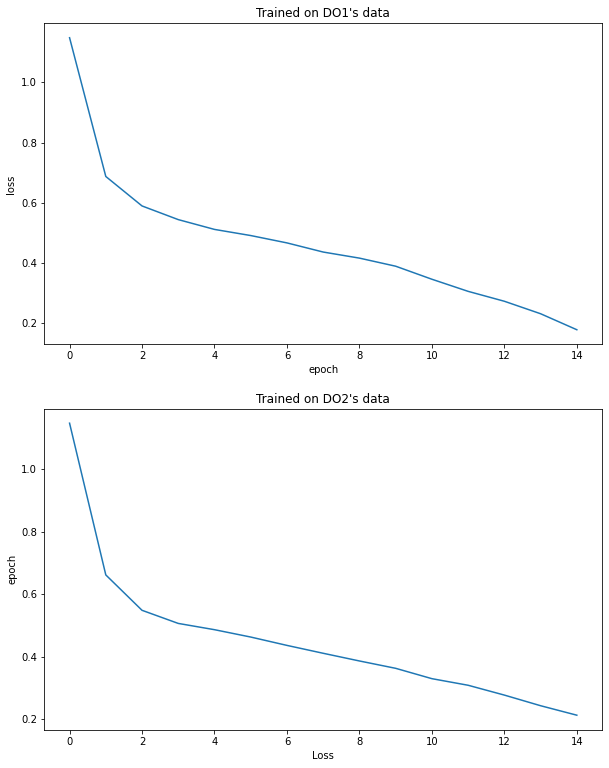

In [24]:
plt.figure(1, figsize=(10, 13))
plt.subplot(2, 1, 1) # row 1, col 2 index 1
plt.plot(range(epochs), losses1)
plt.title("Trained on DO1's data")
plt.xlabel('epoch')
plt.ylabel('loss ')

plt.subplot(2, 1, 2) # index 2
plt.plot(range(epochs), losses2)
plt.title("Trained on DO2's data")
plt.xlabel('Loss')
plt.ylabel('epoch')

plt.show()

Now we will request parameters and updates for both  remote copies of our trained base model . Once again, we don't need to accept the requests since we used the handlers previously.

In [25]:
param1 = remote_model1.parameters().get(request_block=True)
param2 = remote_model2.parameters().get(request_block=True)

#print("Remote model1 parameters:")
#print(param1)
#print()

#print("Remote model2 parameters:")
#print(param2)

In [26]:
remote_model1_updates = remote_model1.get(
    request_block=True
).state_dict()
#print(remote_model1_updates)

remote_model2_updates = remote_model2.get(
    request_block=True
).state_dict()
#print(remote_model2_updates)

# Part 4: Aggregated Model
Now we will do an aggregateegation of the weights. For this case, we will calculate the average of corresponding weights from each model. It should be noted that another interesting strategy is to use the ensamble method, meaning that since we have many (but in our case it is just two, which is not enough) we can use the real data on multiple models at once and provide an average as asn output.

In [27]:
avg_updates = OrderedDict()
avg_updates["fc1.weight"] = (
    remote_model1_updates["fc1.weight"] + remote_model2_updates["fc1.weight"]
) / 2
avg_updates["fc1.bias"] = (
    remote_model1_updates["fc1.bias"] + remote_model2_updates["fc1.bias"]
) / 2
avg_updates["fc1_bn.weight"] = (
    remote_model1_updates["fc1_bn.weight"] + remote_model2_updates["fc1_bn.weight"]
) / 2
avg_updates["fc1_bn.bias"] = (
    remote_model1_updates["fc1_bn.bias"] + remote_model2_updates["fc1_bn.bias"]
) / 2
avg_updates["fc1_bn.running_mean"] = (
    remote_model1_updates["fc1_bn.running_mean"] + remote_model2_updates["fc1_bn.running_mean"]
) / 2
avg_updates["fc1_bn.running_var"] = (
    remote_model1_updates["fc1_bn.running_var"] + remote_model2_updates["fc1_bn.running_var"]
) / 2
avg_updates["fc1_bn.num_batches_tracked"] = (
    remote_model1_updates["fc1_bn.num_batches_tracked"] + remote_model2_updates["fc1_bn.num_batches_tracked"]
) / 2

avg_updates["fc2.weight"] = (
    remote_model1_updates["fc2.weight"] + remote_model2_updates["fc2.weight"]
) / 2
avg_updates["fc2.bias"] = (
    remote_model1_updates["fc2.bias"] + remote_model2_updates["fc2.bias"]
) / 2
avg_updates["fc2_bn.weight"] = (
    remote_model1_updates["fc2_bn.weight"] + remote_model2_updates["fc2_bn.weight"]
) / 2
avg_updates["fc2_bn.bias"] = (
    remote_model1_updates["fc2_bn.bias"] + remote_model2_updates["fc2_bn.bias"]
) / 2
avg_updates["fc2_bn.running_mean"] = (
    remote_model1_updates["fc2_bn.running_mean"] + remote_model2_updates["fc2_bn.running_mean"]
) / 2
avg_updates["fc2_bn.running_var"] = (
    remote_model1_updates["fc2_bn.running_var"] + remote_model2_updates["fc2_bn.running_var"]
) / 2
avg_updates["fc2_bn.num_batches_tracked"] = (
    remote_model1_updates["fc2_bn.num_batches_tracked"] + remote_model2_updates["fc2_bn.num_batches_tracked"]
) / 2

avg_updates["fc3.weight"] = (
    remote_model1_updates["fc3.weight"] + remote_model2_updates["fc3.weight"]
) / 2
avg_updates["fc3.bias"] = (
    remote_model1_updates["fc3.bias"] + remote_model2_updates["fc3.bias"]
) / 2

#print(avg_updates) 

In [28]:
aggregated_model = SyNet(torch)

In [29]:
aggregated_model.load_state_dict(avg_updates)

# Part 5: Testing
We will use the separate data from an external .csv file to check the adequacy of our model 

In [30]:
wine = pd.read_csv("./wine.csv")
wine.head()

,Wine,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,0,13.24,3.98,2.29,17.5,103,2.64,2.63,0.32,1.66,4.36,0.82,3.00,680
1,0,14.38,3.59,2.28,16.0,102,3.25,3.17,0.27,2.19,4.90,1.04,3.44,1065
2,0,13.05,1.73,2.04,12.4,92,2.72,3.27,0.17,2.91,7.20,1.12,2.91,1150
3,0,13.82,1.75,2.42,14.0,111,3.88,3.74,0.32,1.87,7.05,1.01,3.26,1190
4,0,13.77,1.90,2.68,17.1,115,3.00,2.79,0.39,1.68,6.30,1.13,2.93,1375


Separate features and labels

In [31]:
X_test = wine.loc[:, wine.columns != "Wine"]
y_test = wine["Wine"]

Convert to tensors

In [32]:
X_test = torch.FloatTensor(np.array(X_test))
y_test = torch.LongTensor(np.array(y_test))

Save the predictions and get the accuracy

In [33]:
preds = []
aggregated_model.eval()
with torch.no_grad():
    for i in range(len(X_test)):
        sample = X_test[i]
        y_hat = aggregated_model(sample.unsqueeze(0))
        pred = y_hat.argmax().item()
        print(f"Prediction: {pred} Ground Truth: {y_test[i]}")
        preds.append(pred)

Prediction: 2 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 0 Ground Truth: 0
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 1 Ground Truth: 1
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 2 Ground Truth: 2
Prediction: 0 Ground Truth: 2


In [34]:
acc = accuracy_score(y_test, preds)
print("Overall test accuracy", acc * 100)

Overall test accuracy 83.33333333333334


The final results are quite promising considering the simplicity of the model. We can further experiment on the different model configurations.